In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import tensorflow as tf
import time
%matplotlib inline

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# CLASS TO GENERATE DATA

class DataGenerator:
    
    
    def get_batch_single_thread(self, num):
        labels = []
        images = []
        previous_time = time.time()
        print("Generating batch.")
        for i in range(num):
            now_time = time.time()
            if now_time - previous_time > 0.5:
                previous_time = now_time
                print("{} % done.".format((i / num) * 100.0))
                
            label, img = self.make_image()
            labels.append(label)
            images.append(img)
        return labels, images
    
    def get_batch(self, num):
        return self.get_batch_single_thread(num)

    def __init__(self, shape, colours, noise_mean = 0, noise_stdev = 0):
        self.shape=shape
        self.colours=colours
        self.noise_mean = noise_mean
        self.noise_stdev = noise_stdev
        
        self.min_height = int(self.shape[0] * 0.1) + 1
        self.max_height = int(self.shape[0] * 0.8) + 1
        self.min_width = int(self.shape[0] * 0.1) + 1
        self.max_width = int(self.shape[0] * 0.8) + 1
    
    def make_image(self):
        image = np.zeros(shape = self.shape)
        if(random.randint(0,1) == 1): # 50/50 chance of returning a blank image
            colour_index = random.randint(0,len(self.colours) -1 )
            
#             height = random.randint(self.min_height, self.max_height)
#             width = random.randint(self.min_width, self.max_width)
#             x = random.randint(0,self.shape[0] - width)
#             y = random.randint(0,self.shape[1] - height)
            height = 5
            width = 5
            x = int((self.shape[0] - width)/2)
            y = int((self.shape[1] - height)/2)
#             image[x: x + width, y : y + height] = self.colours[colour_index][0]

            for i in range(3):
                image[x: x + width, y : y + height , i] = self.colours[colour_index][i]
#                 colour_labels = np.zeros(len(self.colours))
#                 colour_labels[colour_index] = 1
#                 label = [1, x/self.shape[0] , y/self.shape[1], height / self.shape[0], width / self.shape[1], *colour_labels ]
            label = 1
        else:
#             x = 0
#             y = 0
#             height = 0
#             width = 0
#             colour_labels = np.zeros(len(self.colours))
#             label = [0, x , y, height, width, *colour_labels]
            label = 0
        noise = np.random.normal(loc=self.noise_mean, size = self.shape, scale = self.noise_stdev)
        image = image + noise
        image = np.clip(image, 0, 1 )
        
        return label, image



Generating batch.
label = 0


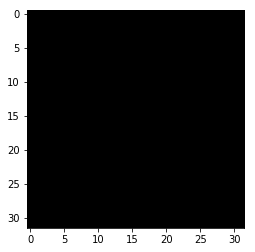

label = 1


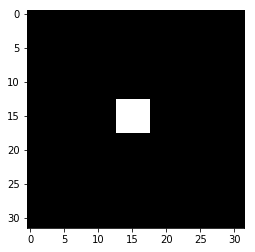

label = 0


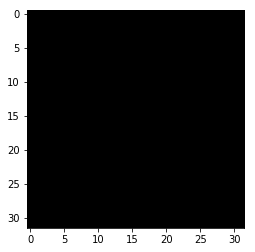

label = 0


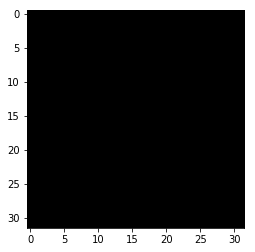

label = 0


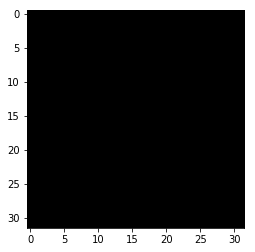

label = 1


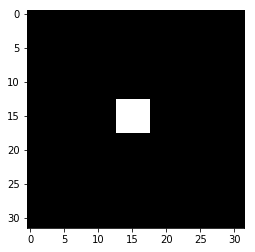

label = 0


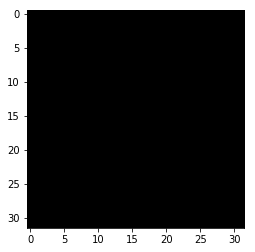

label = 1


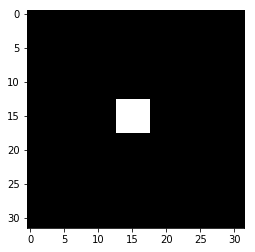

label = 0


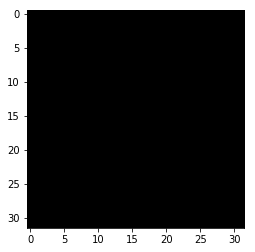

label = 1


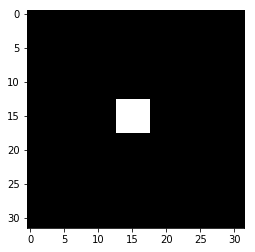

In [3]:
shape = (32,32,3)
# colours = [[1,1,0], [1,0,0], [0,0.5,1]]
colours = [[1,1,1]]
dg = DataGenerator(shape = shape , colours = colours, noise_mean = 0, noise_stdev = 0.00)
random.seed(101)
labels, imgs = dg.get_batch(10)
for i in range(len(imgs)):
    print("label = {}".format(labels[i]))
#     plt.imshow((imgs[i] * 255).astype("uint8"))
    plt.imshow(imgs[i])
    plt.show()

y = \[ is there an object, top left bound box x / image width, top left bound box y / image height, bound box width / image width, bound box height / image height, colour class ... \]

In [600]:
# Create place holders
# x is the input

input_shape = shape[0] * shape[1] * shape[2]
print("input_shape = {}".format(input_shape))

x = tf.placeholder(tf.float32, shape=[None, *shape])


# Variables
num_labels = 1

W = tf.Variable(tf.zeros([input_shape, num_labels]))
b = tf.Variable(tf.zeros([num_labels]))

# Create Graph Operations
reshaper = tf.reshape(x, [-1, input_shape])
z = tf.matmul(reshaper,W) + b

# Loss Function
y_true = tf.placeholder(tf.float32, [None, num_labels])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z))


input_shape = 3072


In [ ]:
# reset random varible
random.seed(101)

# Create Session
batch_size = 10
num_steps = 100
learning_rate = 0.00001

# Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()

accuracies = []
steps = []
rtn = -1

with tf.Session() as sess:
    sess.run(init)
    print(int(num_steps / batch_size))
    for step in range(int(num_steps / batch_size)): # normaize num of steps by batch size
        
        if step % 1 == 0:
            # Evaluate Model
            correct_prediction =  y_true - z
#             accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            accuracy = tf.reduce_mean(y_true - z)
            test_y, test_x = dg.get_batch(batch_size)
            rtn, z_rtn, err = sess.run([accuracy, z, correct_prediction], feed_dict={x:test_x, y_true: test_y})
            accuracies.append(rtn)
            steps.append(step)

        batch_y, batch_x = dg.get_batch(batch_size)
        feed_dict = {x:batch_x, y_true: batch_y}
        sess.run(train, feed_dict=feed_dict)
            
        if step % 10 == 0:
            print("step number {}, error = {}".format(step, rtn))
            print("actual {} predicted {}, err {}".format(test_y[0], z_rtn[0], err[0]))
            plt.imshow(test_x[0])
            plt.show()

plt.plot(steps, accuracies, 'o-')


In [ ]:
accuracies = []
batch_sizes = []
for batch_size in [1, 10, 100]:
    print(batch_size)
    with tf.Session() as sess:
        sess.run(init)
        print(int(num_steps / batch_size))
        for step in range(int(num_steps / batch_size)): # normaize num of steps by batch size
            batch_y, batch_x = dg.get_batch(batch_size)
            feed_dict = {x:batch_x, y_true: batch_y}
            sess.run(train, feed_dict=feed_dict)

        # Evaluate Model
        correct_prediction = tf.equal(tf.argmax(z, 1), tf.argmax(y_true, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        test_y, test_x = dg.get_batch(batch_size)
        rtn = sess.run(accuracy, feed_dict={x:test_x, y_true: test_y})
        accuracies.append(rtn)
        batch_sizes.append(batch_size)

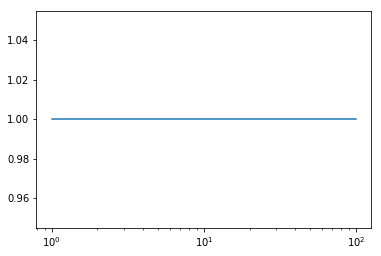

In [64]:
 plt.semilogx(batch_sizes, accuracies)

## Using CNN from Tensorflow Tutoria

In [74]:
# Advanced Network Network

def cnn_model_fn(features, labels, mode):
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=features['x'],
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = { "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

Generating batch.
label = 0


label = 1


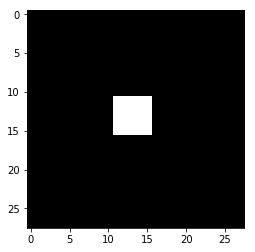

In [95]:
shape = (28,28,3)
colours = [[1,1,0], [1,0,0], [0,0.5,1]]
colours = [[1,1,1]]
dg = DataGenerator(shape = shape , colours = colours, noise_mean = 0, noise_stdev = 0)

# reset random varible
random.seed(101)
labels, imgs = dg.get_batch(2)
for i in range(len(imgs)):
    print ("label = {}".format(labels[i]))
    plt.imshow((imgs[i] * 255).astype('uint8'))
    plt.show()

In [96]:
# Generate Data
random.seed(101)
train_labels, train_data = dg.get_batch(50000)
train_labels = np.asarray(train_labels, dtype=np.int32)
train_data = np.asarray(train_data)
eval_labels, eval_data = dg.get_batch(5000)
eval_labels = np.asarray(eval_labels, dtype=np.int32)
eval_data = np.asarray(eval_data)
print("Done Generating Trainging and Eval Data")

Generating batch.
8.649999999999999 % done.
16.75 % done.
23.812 % done.
32.300000000000004 % done.
40.778 % done.
49.266 % done.
57.95400000000001 % done.
66.622 % done.
73.76 % done.
81.238 % done.
89.63799999999999 % done.
97.61800000000001 % done.
Generating batch.
80.38 % done.
Done Generating Trainging and Eval Data


In [98]:
# Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="C:\\Users\\Administrator\\Documents\\AIClub\\hello_world\\Sandbox\\tmp")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Administrator\\Documents\\AIClub\\hello_world\\Sandbox\\tmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021E32950278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [99]:
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [100]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
classifier.train(
    input_fn=train_input_fn,
    steps=100,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Administrator\Documents\AIClub\hello_world\Sandbox\tmp\model.ckpt-4639
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 4640 into C:\Users\Administrator\Documents\AIClub\hello_world\Sandbox\tmp\model.ckpt.
INFO:tensorflow:probabilities = [[0.00004972 0.99995028]
 [0.00012763 0.99987237]
 [0.99292803 0.00707197]
 [0.99211477 0.00788523]
 [0.98959461 0.01040539]
 [0.98907288 0.01092712]
 [0.99123076 0.00876924]
 [0.98984782 0.01015218]
 [0.99442718 0.00557282]
 [0.00010788 0.99989212]
 [0.99521095 0.00478905]
 [0.00014719 0.99985281]
 [0.00003694 0.99996306]
 [0.99499251 0.00500749]
 [0.9871295  0.0128705 ]
 [0.99069319 0.00930681]
 [0.00009015 0.99990985]
 [0.00006021 0.99993979]
 [0.99223596 0.00776404]
 [0.99076

In [102]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-01-02:58:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Administrator\Documents\AIClub\hello_world\Sandbox\tmp\model.ckpt-4739
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-01-02:58:13
INFO:tensorflow:Saving dict for global step 4739: accuracy = 1.0, global_step = 4739, loss = 0.003910065
{'accuracy': 1.0, 'loss': 0.003910065, 'global_step': 4739}
